# Crash Data Analysis

Every year, Melbourne area has roughly 13000 accidents in all the states. The following is the number of crashes per year from 2006 to early March 2019 separated by the severity of the crashes.

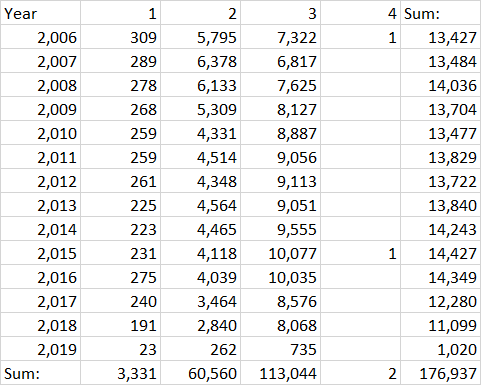

This following project is to analyse what factors may cause a crash and the severity of the crash based on multiple factors. This is particularly useful for government to reduce the number of crashes in the future by improving the conditions of the roads based on the factors that are used in this project.

In [1]:
# Standard libraries
%matplotlib inline
from datetime import datetime
import numpy as np
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from timeit import default_timer as timer

from pandas_profiling import ProfileReport

# Modelling
    # Ensemble modelling
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
    # Logistic Regression model
from sklearn.linear_model import LogisticRegression
    # K-Nearest Neighbors model
from sklearn.neighbors import KNeighborsClassifier
    # Decision Tree model
from sklearn.tree import DecisionTreeClassifier
    # Random Forest model
from sklearn import tree
    # Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

# Scoring
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
crash = pd.read_csv('./data/Input_data.csv', index_col = 'ACCIDENT_NO')

C:\Users\User\Anaconda3_2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (10,56,86,89,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
crash.head(5)

,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,EDITION,...,Inj Level Desc,SEATING_POSITION,HELMET_BELT_WORN,ROAD_USER_TYPE,Road User Type Desc,LICENCE_STATE,PEDEST_MOVEMENT,POSTCODE,TAKEN_HOSPITAL,EJECTED_CODE
ACCIDENT_NO,,,,,,,,,,,,,,,,,,,,,
T20060000010,13/01/2006,12.42.00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,...,Not injured,LF,1,3,Passengers,,0,3130.0,,0
T20060000010,13/01/2006,12.42.00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,...,Not injured,LF,1,3,Passengers,,0,7310.0,,0
T20060000010,13/01/2006,12.42.00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,...,Not injured,LR,1,3,Passengers,,0,7310.0,,0
T20060000010,13/01/2006,12.42.00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,...,Not injured,D,1,2,Drivers,V,0,3130.0,,0
T20060000010,13/01/2006,12.42.00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,40,...,Other injury,D,1,2,Drivers,V,0,NaN,N,0


In [4]:
print("=" * 73)
print("| Number of data        : %7d                                       |" % crash.shape[0])
print("| Number of features    : %7d                                       |" % crash.shape[1])
print("=" * 73)
print("| No. | Column Name               | Data Types      | Unique  | Nulls   |")
print("|" + "-" * 5 + "|" + "-" * 27 + "|" + "-" * 17 + "|" + "-" * 9 + "|" + "-" * 9 + "|")
count = 0
for c in crash.columns:
    count += 1
    print("| %3d | %25s | %15s | %7d | %7d |"  % (count, str(c), str(crash[c].dtypes), crash[c].nunique(), crash[c].isna().sum()))
print("=" * 73)

| Number of data        :  894188                                       |
| Number of features    :      92                                       |
| No. | Column Name               | Data Types      | Unique  | Nulls   |
|-----|---------------------------|-----------------|---------|---------|
|   1 |              ACCIDENTDATE |          object |    4806 |       0 |
|   2 |              ACCIDENTTIME |          object |    1440 |       0 |
|   3 |             ACCIDENT_TYPE |           int64 |       9 |       0 |
|   4 |        Accident Type Desc |          object |       9 |       0 |
|   5 |               DAY_OF_WEEK |           int64 |       8 |       0 |
|   6 |      Day Week Description |          object |       7 |       0 |
|   7 |                  DCA_CODE |           int64 |      81 |       0 |
|   8 |           DCA Description |          object |      81 |       0 |
|   9 |                 DIRECTORY |          object |       3 |   21331 |
|  10 |                   EDITION |   

In [5]:
crash = crash[['ACCIDENTDATE', 'SEVERITY', 'VEHICLE_YEAR_MANUF', 'SEX', 'AGE', \
               'ATMOSPH_COND', 'Atmosph Cond Desc', \
               'ROAD_SURFACE_TYPE', 'Road Surface Type Desc', \
               'LIGHT_CONDITION', 'Light Condition Desc', \
               'SURFACE_COND', 'Surface Cond Desc',\
               'ROAD_GEOMETRY', 'Road Geometry Desc', \
               'VEHICLE_TYPE', 'Vehicle Type Desc']]

In [6]:
crash['SEX'].replace('U', np.nan, inplace = True)
crash['ATMOSPH_COND'].replace(9, np.nan, inplace = True)
crash['ROAD_SURFACE_TYPE'].replace(9, np.nan, inplace = True)
crash['LIGHT_CONDITION'].replace(9, np.nan, inplace = True)
crash['SURFACE_COND'].replace(9, np.nan, inplace = True)
crash['ROAD_GEOMETRY'].replace(9, np.nan, inplace = True)
crash['VEHICLE_TYPE'].replace(99, np.nan, inplace = True)

In [7]:
crash.drop_duplicates(inplace = True)

In [8]:
crash.dropna(inplace = True)

-------------------------------------------------------------------------------------------------------------------------------

The histograms

1. Atmospheric Cond Description
2. Road Surface Type Description
3. Light Condition Description
4. Surface Cond Description
5. Road Geometry Description
6. Vehicle Type Description

Atmosph Cond Desc
['Clear' 'Smoke' 'Strong winds' 'Raining' 'Dust' 'Fog' 'Snowing']
--------------------------------------------------------------------------------


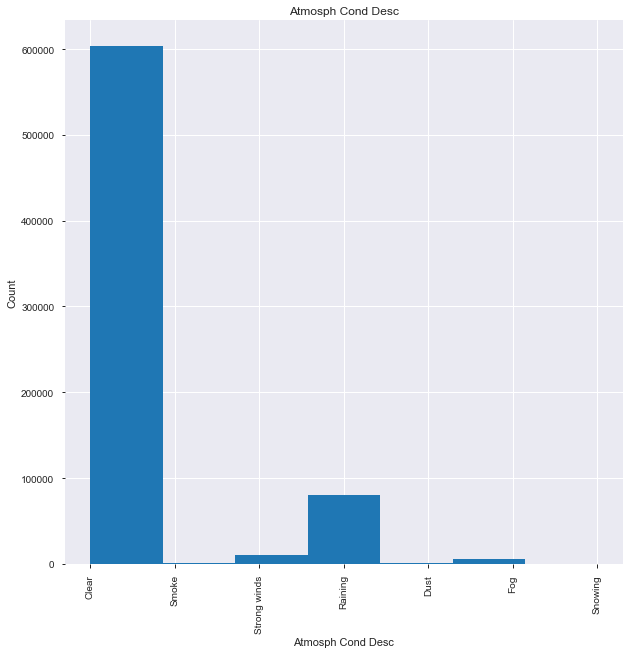

--------------------------------------------------------------------------------
Road Surface Type Desc
['Paved' 'Unpaved' 'Gravel']
--------------------------------------------------------------------------------


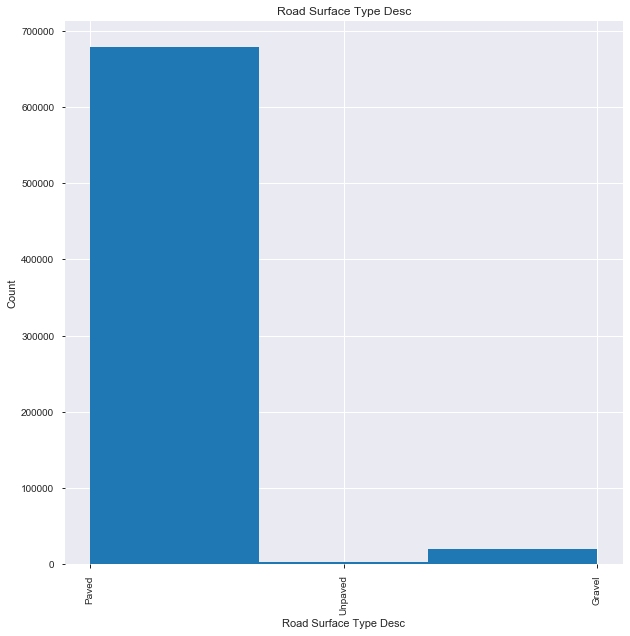

--------------------------------------------------------------------------------
Light Condition Desc
['Day' 'Dark Street lights on' 'Dusk/Dawn' 'Dark No street lights'
 'Dark Street lights off' 'Dark Street lights unknown']
--------------------------------------------------------------------------------


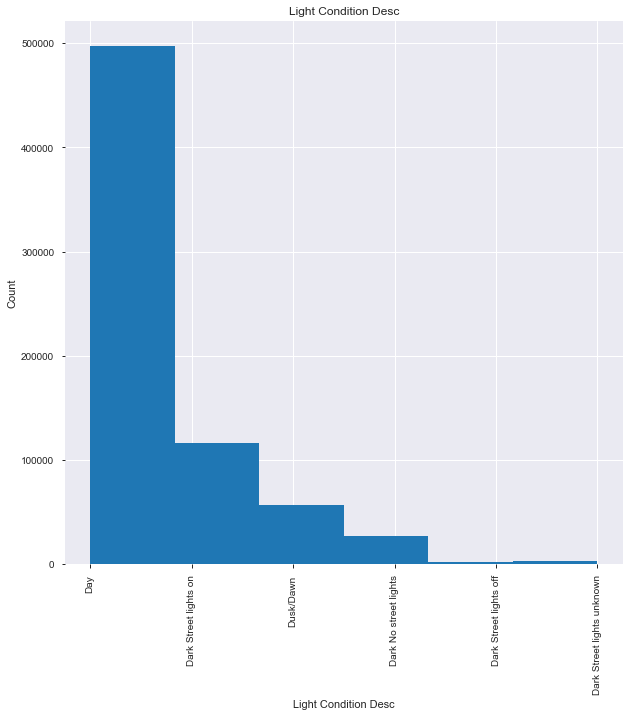

--------------------------------------------------------------------------------
Surface Cond Desc
['Dry' 'Wet' 'Muddy' 'Icy' 'Snowy']
--------------------------------------------------------------------------------


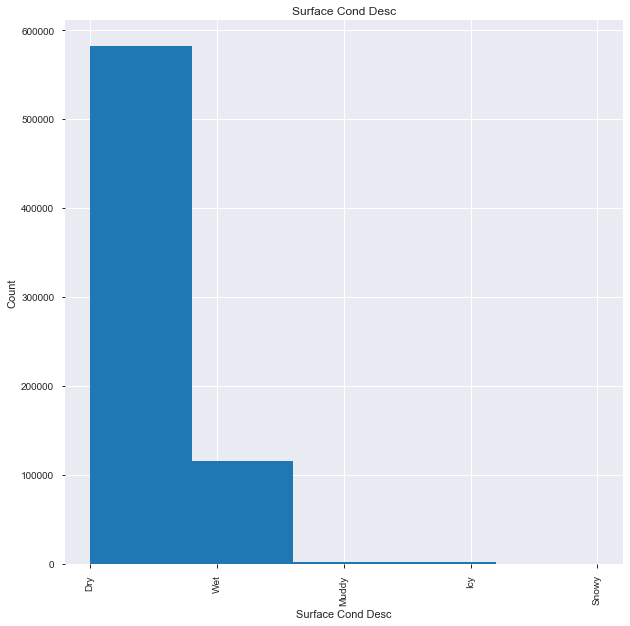

--------------------------------------------------------------------------------
Road Geometry Desc
['Cross intersection' 'T intersection' 'Not at intersection'
 'Multiple intersection' 'Y intersection' 'Dead end' 'Private property'
 'Road closure']
--------------------------------------------------------------------------------


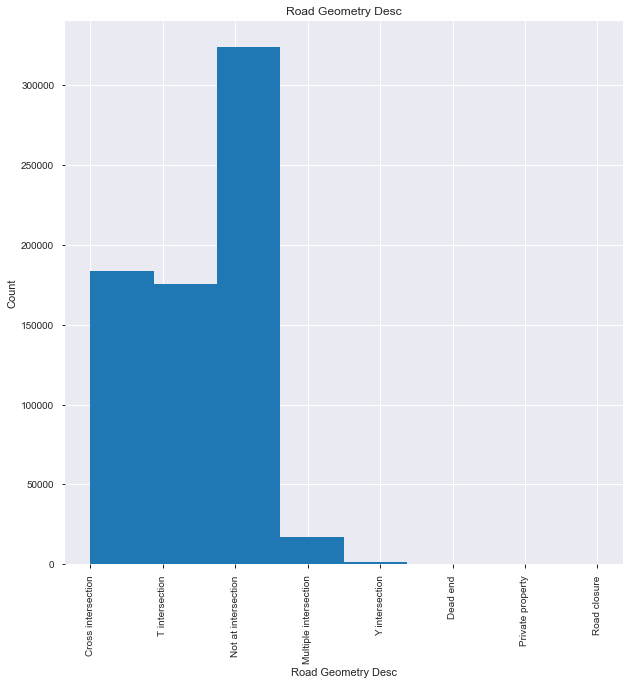

--------------------------------------------------------------------------------
Vehicle Type Desc
['Car' 'Taxi' 'Utility' 'Motor Cycle'
 'Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM' 'Panel Van'
 'Station Wagon' 'Prime Mover (No of Trailers Unknown)'
 'Heavy Vehicle (Rigid) > 4.5 Tonnes' 'Bicycle' 'Other Vehicle'
 'Rigid Truck(Weight Unknown)' 'Motor Scooter' 'Mini Bus(9-13 seats)'
 'Bus/Coach' 'Moped' 'Prime Mover Only' 'Prime Mover - Single Trailer'
 'Horse (ridden or drawn)' 'Tram' 'Not Applicable' 'Prime Mover B-Double'
 'Prime Mover B-Triple' 'Train'
 'Plant machinery and Agricultural equipment' 'Quad Bike'
 'Parked trailers']
--------------------------------------------------------------------------------


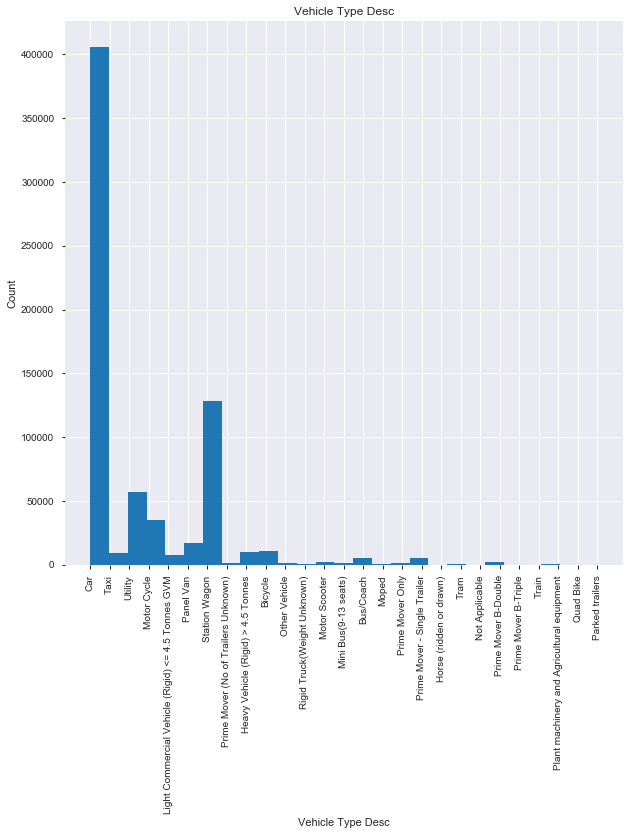

--------------------------------------------------------------------------------


In [9]:
col = ['Atmosph Cond Desc', 'Road Surface Type Desc', \
       'Light Condition Desc', 'Surface Cond Desc', \
       'Road Geometry Desc', 'Vehicle Type Desc']

for c in col:
    print(c)
    print(crash[c].unique())
    print('-' * 80)
    
    plt.figure(figsize=(10,10))
    
    plt.hist(crash[c], bins = crash[c].nunique(), align = 'mid')   
    
    # Add labels
    plt.title(c)
    plt.xlabel(c)
    plt.ylabel('Count')
    
    plt.xticks(rotation=90)
    
    name = c + '.png'
    
    plt.savefig(name)
    
    plt.show()
    
    print('-' * 80)

In [10]:
crash['ACCIDENTDATE'] = pd.to_datetime(crash['ACCIDENTDATE'], format='%d/%m/%Y')
crash['ACCIDENT_YEAR'] = crash['ACCIDENTDATE'].apply(lambda x: x.strftime("%Y"))
crash['VEHICLE_AGE'] = crash['ACCIDENT_YEAR'].apply(lambda x: int(x)) - crash['VEHICLE_YEAR_MANUF']

In [11]:
crash.loc[:, ('Atmosph Cond Desc', 'Road Surface Type Desc', \
              'Light Condition Desc', 'Surface Cond Desc', 'Road Geometry Desc', \
              'Vehicle Type Desc', 'VEHICLE_AGE', 'AGE', 'SEX')].dropna(inplace = True)

In [12]:
crash['severity_dummy'] = crash['SEVERITY'].apply(lambda x: 0 if x < 3 else 1)

The following shows the features being dummified and saved in another dataframe.

In [13]:
gender_dummy = pd.get_dummies(crash['SEX'], drop_first = True)
atmos_dummy = pd.get_dummies(crash['Atmosph Cond Desc'], drop_first = True)
road_dummy = pd.get_dummies(crash['Road Surface Type Desc'], drop_first = True)
light_dummy = pd.get_dummies(crash['Light Condition Desc'], drop_first = True)
surface_dummy = pd.get_dummies(crash['Surface Cond Desc'], drop_first = True)
road_geo_dummy = pd.get_dummies(crash['Road Geometry Desc'], drop_first = True)
vehicle_dummy = pd.get_dummies(crash['Vehicle Type Desc'], drop_first = True)

In [14]:
dummy_list = [gender_dummy, atmos_dummy, road_dummy, light_dummy, \
              surface_dummy, road_geo_dummy,\
              vehicle_dummy]

df = pd.DataFrame(crash[['severity_dummy', 'VEHICLE_AGE', 'AGE']])

for d in dummy_list:
    df = pd.concat([df, d], axis = 1)
    
df.drop_duplicates(inplace = True)
df.fillna(df.median(), inplace = True)

df

,severity_dummy,VEHICLE_AGE,AGE,M,Dust,Fog,Raining,Smoke,Snowing,Strong winds,...,Prime Mover B-Double,Prime Mover B-Triple,Prime Mover Only,Quad Bike,Rigid Truck(Weight Unknown),Station Wagon,Taxi,Train,Tram,Utility
ACCIDENT_NO,,,,,,,,,,,,,,,,,,,,,
T20060000010,1,10.0,43.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T20060000010,1,10.0,22.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T20060000010,1,10.0,72.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T20060000010,1,10.0,62.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T20060000010,1,10.0,39.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T20190003541,0,17.0,24.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T20190003541,0,21.0,27.0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
T20190003629,0,1.0,43.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


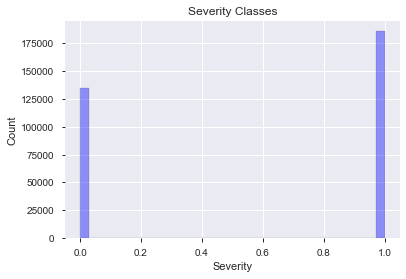

In [15]:
sns.distplot(df['severity_dummy'], hist=True, kde=False, bins=int(180/5), color = 'blue', hist_kws={'edgecolor':'black'})    
    
# Add labels
plt.title('Severity Classes')
plt.xlabel('Severity')
plt.ylabel('Count')

plt.show()

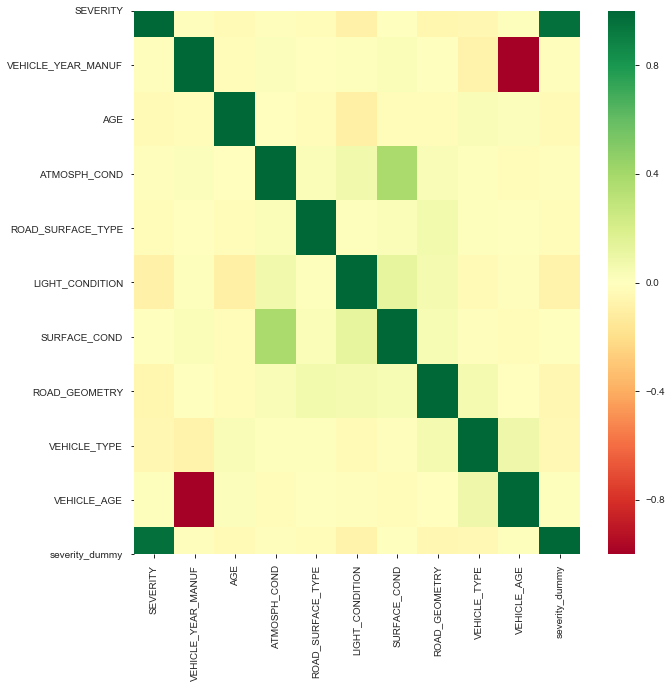

In [45]:
corrmat = crash.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(crash[top_corr_features].corr(),cmap="RdYlGn")

plt.savefig('heatmap.png')

plt.show()

In [17]:
COUNT = 0

print('=' * 70)
print('| No. | %60s |' % ('Column'))
print('=' * 70)
for col in df.columns:
    COUNT += 1
    print('| %3d | %60s |' % (COUNT, col))
    print('-' * 70)
print('=' * 70)

| No. |                                                       Column |
|   1 |                                               severity_dummy |
----------------------------------------------------------------------
|   2 |                                                  VEHICLE_AGE |
----------------------------------------------------------------------
|   3 |                                                          AGE |
----------------------------------------------------------------------
|   4 |                                                            M |
----------------------------------------------------------------------
|   5 |                                                         Dust |
----------------------------------------------------------------------
|   6 |                                                          Fog |
----------------------------------------------------------------------
|   7 |                                                      Raining |
------

-------------------------------------------------------------------------------------------------------------------------------

# Hypothesis and Models

Distinct Accident Count for Accident, Person, Vehicle, Accident_Event, Accident_Location, Atmospheric_Cond, Road_Surface_Cond are expected to be the same. SubDCA is expected less as not all DCA code required subdca coded. Node is expected less as not all crashes could be geo located successfully. Node ID Complex Intersection ID is also expected less as it is only applicable to intersections classified as complex intersection. 

From all the data given, it is hypothesized that the following features may explain the severity of the crash:
1. Atmospheric Cond
2. Road Surface Type 
3. Light Condition 
4. Surface Cond 
5. Road Geometry 
6. Vehicle Type 
5. Gender of the person driving
6. Age of the person driving

In [31]:
# Setting predictors and target

col = [c for c in df.columns if c is not 'severity_dummy' or c is not 'VEHICLE_AGE']

X = df[col]
y = df['severity_dummy']

X.drop('severity_dummy', axis = 1, inplace = True)

The following is the baseline accuracy for the models.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Models running for this section are: 

1. Decision Tree
2. KNN
3. Logistic Regression
4. Support Vector Machine
5. K-Means
6. Naive Bayes, Gaussian
7. Random Forest
8. Gradient Boosting

The accuracy, time taken to run and ROC-AUC will be recorded and compared.

In [33]:
np.random.seed(0)
clf1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2)
clf2 = KNeighborsClassifier(n_neighbors = 2)
clf3 = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
clf4 = GaussianNB()
clf5 = RandomForestClassifier(n_estimators = 100, max_depth = 100)
clf6 = GradientBoostingClassifier()

In [34]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [35]:
label = ['Decision Tree', 'K-NN', \
         'Logistic Regression', 'Naive Bayes', \
         'Random Forest', 'Gradient Boost']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6]
train_list = []

for clf, label in zip(clf_list, label):    
    print("=" * 80)
    print(label)
    print("-" * 80)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average = 'micro')
    recall = recall_score(y_train, y_pred, average = 'micro')
    roc_auc = multiclass_roc_auc_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    
    print('Accuracy  : %.2f' % accuracy)
    print('Precision : %.2f' % precision)
    print('Recall    : %.2f' % recall)
    print('ROC AUC   : %.2f' % roc_auc)
    print('F1        : %.2f' % f1)
    
    print("=" * 80)
    train_list.append([label, accuracy, precision, recall, roc_auc, f1])

Accuracy  : 0.58
Precision : 0.58
Recall    : 0.58
ROC AUC   : 0.51
F1        : 0.73
Accuracy  : 0.69
Precision : 0.69
Recall    : 0.69
ROC AUC   : 0.73
F1        : 0.63
Accuracy  : 0.59
Precision : 0.59
Recall    : 0.59
ROC AUC   : 0.52
F1        : 0.72
Accuracy  : 0.58
Precision : 0.58
Recall    : 0.58
ROC AUC   : 0.53
F1        : 0.70
Accuracy  : 0.85
Precision : 0.85
Recall    : 0.85
ROC AUC   : 0.85
F1        : 0.88
Accuracy  : 0.59
Precision : 0.59
Recall    : 0.59
ROC AUC   : 0.52
F1        : 0.73


The following is the result of the trainings for each models.

In [36]:
result_train2 = pd.DataFrame(train_list, columns = ['label', 'accuracy', 'precision', 'recall', 'roc_auc', 'F1 score'])

In [37]:
result_train2

,label,accuracy,precision,recall,roc_auc,F1 score
0,Decision Tree,0.582497,0.582497,0.582497,0.511341,0.725591
1,K-NN,0.687829,0.687829,0.687829,0.731415,0.632787
2,Logistic Regression,0.587113,0.587113,0.587113,0.524381,0.719444
3,Naive Bayes,0.577015,0.577015,0.577015,0.526927,0.696603
4,Random Forest,0.854232,0.854232,0.854232,0.847074,0.876632
5,Gradient Boost,0.590650,0.590650,0.590650,0.521304,0.729253


In [38]:
result_train2.to_csv('./data/train_result2.csv')

In [39]:
label = ['Decision Tree', 'K-NN', \
         'Logistic Regression', 'Naive Bayes', \
         'Random Forest', 'Gradient Boost']
clf_list = [clf1, clf2, clf3, clf4, clf5, clf6]
test_list = []

for clf, label in zip(clf_list, label): 
    print("=" * 80)
    print(label)
    print("-" * 80)
    
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'micro')
    recall = recall_score(y_test, y_pred, average = 'micro')
    roc_auc = multiclass_roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print('Accuracy  : %.2f' % accuracy)
    print('Precision : %.2f' % precision)
    print('Recall    : %.2f' % recall)
    print('ROC AUC   : %.2f' % roc_auc)
    print('F1        : %.2f' % f1)
    
    print("=" * 80)
    test_list.append([label, accuracy, precision, recall, roc_auc, f1])

Decision Tree
--------------------------------------------------------------------------------
Accuracy  : 0.58
Precision : 0.58
Recall    : 0.58
ROC AUC   : 0.51
F1        : 0.72
K-NN
--------------------------------------------------------------------------------
Accuracy  : 0.42
Precision : 0.42
Recall    : 0.42
ROC AUC   : 0.45
F1        : 0.34
Logistic Regression
--------------------------------------------------------------------------------
Accuracy  : 0.59
Precision : 0.59
Recall    : 0.59
ROC AUC   : 0.53
F1        : 0.72
Naive Bayes
--------------------------------------------------------------------------------
Accuracy  : 0.57
Precision : 0.57
Recall    : 0.57
ROC AUC   : 0.53
F1        : 0.69
Random Forest
--------------------------------------------------------------------------------
Accuracy  : 0.44
Precision : 0.44
Recall    : 0.44
ROC AUC   : 0.42
F1        : 0.53
Gradient Boost
--------------------------------------------------------------------------------
Accuracy 

The following is the result of testing for each models.

In [40]:
result_test2 = pd.DataFrame(test_list, columns = ['label', 'accuracy', 'precision', 'recall', 'roc_auc', 'F1 score'])

In [41]:
result_test2

,label,accuracy,precision,recall,roc_auc,F1 score
0,Decision Tree,0.580545,0.580545,0.580545,0.512559,0.723971
1,K-NN,0.417155,0.417155,0.417155,0.445442,0.341774
2,Logistic Regression,0.585844,0.585844,0.585844,0.526133,0.717894
3,Naive Bayes,0.573759,0.573759,0.573759,0.525685,0.693926
4,Random Forest,0.440102,0.440102,0.440102,0.421606,0.527477
5,Gradient Boost,0.586382,0.586382,0.586382,0.520362,0.725730


In [42]:
result_test2.to_csv('./data/test_result2.csv')

_______________________________________________________________________________________________________________________________